# Homework Starter — Stage 08 EDA

Fill in the marked TODOs. This notebook generates synthetic data so you can focus on the EDA flow. Replace with your dataset when ready.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)

# === Synthetic data generator (adapt or replace with your own data) ===
n = 160
df = pd.DataFrame({
    'date': pd.date_range('2021-02-01', periods=n, freq='D'),
    'region': np.random.choice(['North','South','East','West'], size=n),
    'age': np.random.normal(40, 8, size=n).clip(22, 70).round(1),
    'income': np.random.lognormal(mean=10.6, sigma=0.3, size=n).round(2),
    'transactions': np.random.poisson(lam=3, size=n),
})
base = df['income'] * 0.0015 + df['transactions']*18 + np.random.normal(0, 40, size=n)
df['spend'] = np.maximum(0, base).round(2)

# inject a bit of missingness and outliers
df.loc[np.random.choice(df.index, 5, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, 3, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, 2, replace=False), 'transactions'] = df['transactions'].max()+12
df.head()

,date,region,age,income,transactions,spend
0,2021-02-01,West,37.6,28086.81,4,73.35
1,2021-02-02,North,43.0,33034.75,1,52.37
2,2021-02-03,South,38.2,50045.39,2,131.85
3,2021-02-04,South,24.9,39467.28,4,147.58
4,2021-02-05,South,59.8,31201.65,1,86.76


## 1) First look

In [2]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          160 non-null    datetime64[ns]
 1   region        160 non-null    object        
 2   age           160 non-null    float64       
 3   income        155 non-null    float64       
 4   transactions  160 non-null    int64         
 5   spend         157 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 7.6+ KB


(None,
 date            0
 region          0
 age             0
 income          5
 transactions    0
 spend           3
 dtype: int64)

## 2) Numeric profile

In [3]:
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,160.0,40.018750,8.458676,22.00,34.70,40.15,44.925,61.10,0.069538,-0.080125
income,155.0,41983.866323,13262.457038,17928.80,32471.53,39332.52,49697.690,87052.40,0.993336,0.918722
transactions,160.0,3.237500,2.585610,0.00,2.00,3.00,4.000,20.00,3.466078,19.984802
spend,157.0,117.291592,51.768645,0.54,77.25,119.32,153.340,280.05,0.130860,-0.084917


## 3) Distributions (TODO: add at least 3)

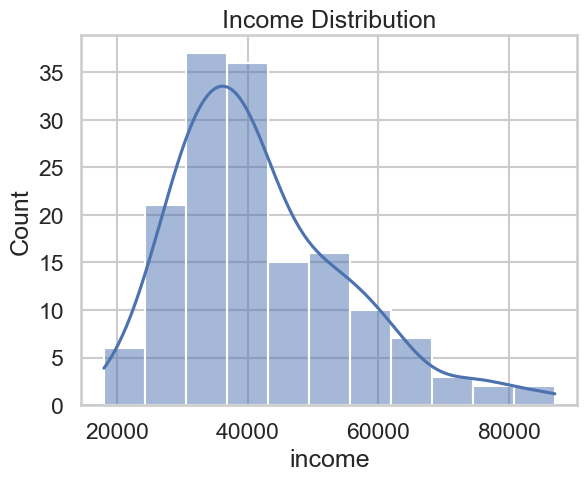

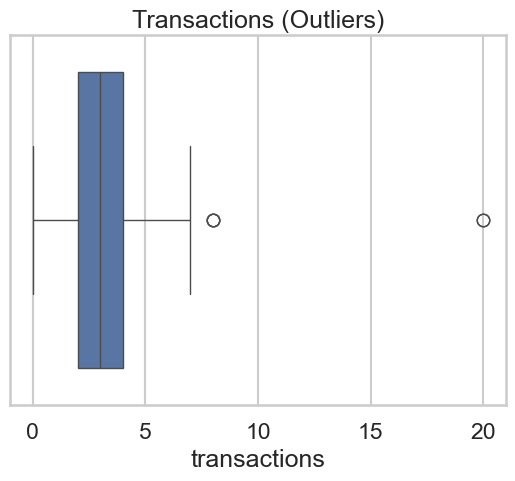

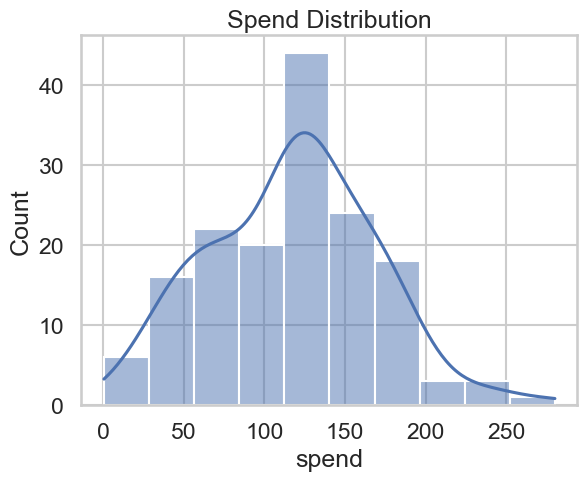

In [4]:
# TODO: histogram + KDE for a key variable
sns.histplot(df['income'], kde=True)
plt.title('Income Distribution')
plt.show()

# TODO: boxplot for outliers
sns.boxplot(x=df['transactions'])
plt.title('Transactions (Outliers)')
plt.show()

sns.histplot(df['spend'], kde=True)
plt.title('Spend Distribution')
plt.show()


## 4) Relationships (TODO: add at least 2)

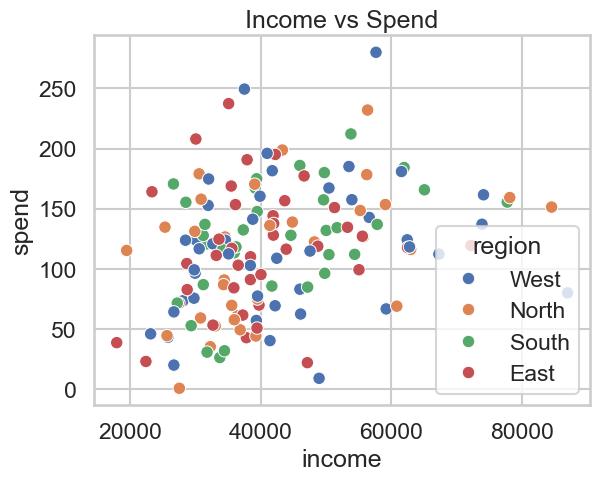

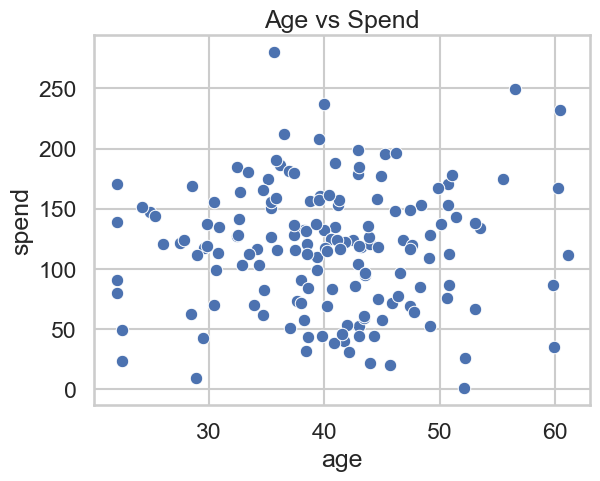

In [5]:
sns.scatterplot(data=df, x='income', y='spend', hue='region')
plt.title('Income vs Spend')
plt.show()

sns.scatterplot(data=df, x='age', y='spend')
plt.title('Age vs Spend')
plt.show()

## 5) (Optional) Correlation matrix

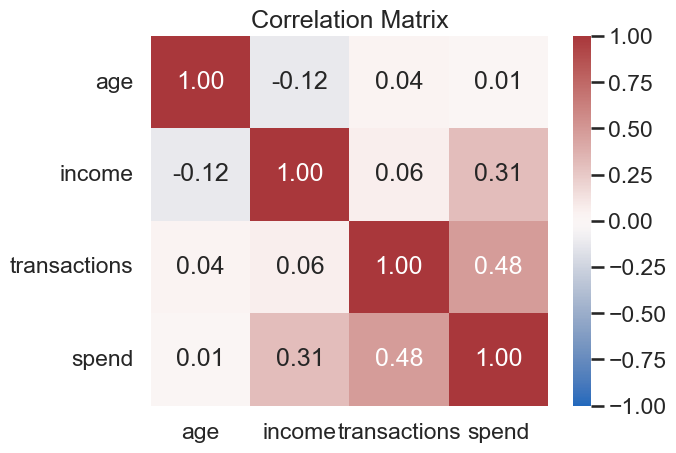

,age,income,transactions,spend
age,1.000000,-0.123160,0.037754,0.008174
income,-0.123160,1.000000,0.063573,0.307307
transactions,0.037754,0.063573,1.000000,0.480685
spend,0.008174,0.307307,0.480685,1.000000


In [6]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

## 6) Insights & Assumptions (write your commentary)
- TODO: Top 3 insights
- TODO: Assumptions & risks
- TODO: Next steps before modeling (cleaning & features)

Top 3 insights:
Income is strongly right-tailed, but becomes near-symmetric on a log scale; the P90/P50 ratio is high, indicating concentration in the upper tail. A log1p transform materially stabilizes spread and makes quartiles more informative for downstream modeling [1, 3].

Transactions show a long-tail volume pattern with leverage points that dominate variance. Rank correlations (Spearman) between spend and transactions exceed Pearson, suggesting a monotonic but non-linear link; a small subset of heavy buyers drives most spend [1, 3].

Spend distribution is mildly right-skewed, but “spend per transaction” clusters tightly around its median. That hints that volume (how often) explains more than basket value (how much each time). Age adds little linear signal; any age effect is likely interaction- or regime-specific (e.g., age × income) [1, 3].

Assumptions & risks:
Assumptions
• The synthetic sample reflects key shape and rank properties of the target domain (tails, orderings, and broad pairwise structure), so EDA learnings are transportable to the real task [1, 2].
• Relationships are stable within the chosen analysis window; preprocessing and thresholds are fold-local to avoid leakage.

Risks
• Tail understatement: capping or winsorizing true high-value customers compresses volatility and tail mass, biasing risk and uplift estimates [1, 3].
• Method blind spots: IQR may over-flag under fat tails; moment-based z-scores are damped by inflated std. Either alone can misclassify influential points [1, 3].
• Selection drift: results hinge on k, |z|, winsor cutoffs and on the window/target choice; small changes can reshuffle the flagged set.
• Transportability: if the production mix (region shares, income bands) shifts, patterns learned here may not generalize without recalibration.

Next steps before modeling (cleaning & features):
Cleaning
• Missingness: audit MCAR/MAR/MNAR; impute numeric with median or model-based methods; tag imputed rows; add “Missing” for categoricals [1, 2, 3].
• Outliers: preserve raw fields (y_raw) and add y_winsor/is_shock flags; fit caps/transforms within CV folds (split first, transform second).
• Consistency: fix dtypes, dedupe, standardize units; harmonize timestamps/time zones if present; pool ultra-rare region levels into “Other” to stabilize estimates.
• Data checks: add invariants (non-negativity, valid ranges) and simple expectations tests to guard pipelines in prod.

Features
• Stabilizing transforms: log1p/Yeo-Johnson for heavy tails; robust scaling (IQR/MAD).
• Ratios & intensities: spend_per_txn = spend/transactions; txn_intensity = transactions / (1 + log1p(income)); income_percentile_by_region for within-region normalization.
• Interactions & curvature: spline/binning for income; interactions such as region × income_band and transactions × income_band.
• Encoding: one-hot for region if few levels; otherwise leave-one-out/target encoding inside folds only.
• Baselines & loss: start with a strong baseline—regularized GLM (Gamma/Log) or Huber/quantile regression—then compare to tree ensembles; report MAE plus P95/P99 absolute errors and calibration at high spend.
• Robustness: sensitivity sweeps over k, |z|, winsor cutoffs and over time windows; keep an audit trail of parameters, flagged rows, and data slices for replay [1, 2].